# Investment Analysis and Decision Modelling on Importers

## 1. Exploratory Data Analysis

### 1.1 Data Preparation

In [1]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import plotly.graph_objs as go
import squarify #TreeMap
import matplotlib.pyplot as plt

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

In [2]:
# load dataset
raw1 = pd.read_csv('main.csv', compression='gzip')
raw2 = pd.read_csv('ports.csv')
raw3 = pd.read_csv('importer_normalized_data.csv')

In [3]:
main =raw1.copy()
port = raw2.copy()
consignee = raw3.copy()

In [4]:
# drop unnecessary columns from the dataset
main.drop(columns='Unnamed: 0', inplace=True)
port.drop(columns='Unnamed: 0', inplace=True)
consignee.drop(columns='Unnamed: 0', inplace=True)

In [5]:
main.dtypes

consignee             object
calculated_teu       float64
file_month             int64
port_of_unlading       int64
country_of_origin     object
hs_codes              object
dtype: object

In [6]:
# create a month_name column
main['month_name'] = pd.to_datetime(main['file_month'], format='%m').dt.month_name()

In [7]:
# split the consignee column into name and address
main[['name','address']]=main.consignee.str.split(", address=", n=1, expand=True)

In [8]:
# drop the consignee column
main.drop(columns='consignee', inplace=True)

In [9]:
# remove unwanted substring under name column
main['name'] = main['name'].str.replace("{name=","")

C:\Users\Morax\AppData\Local\Temp/ipykernel_20704/2194513621.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [10]:
# reorder the columns
cols = main.columns.tolist()
cols = cols[-2:] + cols[:-2]
main = main[cols]

In [11]:
# drop duplicates on the port dataset
port.drop_duplicates(subset=['port_code'], keep='first', inplace=True)

In [12]:
# merge main with port dataset to get port name
main_merged = main.merge(port, how='left', left_on='port_of_unlading', right_on='port_code')
# drop port_code column
main_merged.drop(columns='port_code', inplace=True)

In [13]:
# drop duplicates on the consignee dataset
consignee.drop_duplicates(subset=['importer_raw_name'], keep='first', inplace=True)

In [14]:
consignee

,importer_rank,importer_raw_name,importer_deduped_name
0,1,DOLE FRESH FRUIT,DOLE FRESH FRUIT COMPANY
1,1,DOLE FRESH FRUIT CO.,DOLE FRESH FRUIT COMPANY
2,1,DOLE FRESH FRUIT COMPANY,DOLE FRESH FRUIT COMPANY
3,1,DOLE FRESH FRUITS,DOLE FRESH FRUIT COMPANY
4,2,SAMSUNG ELECTORNICS,SAMSUNG ELECTRONICS AMERICA INC
...,...,...,...
46170,9981,"ZHONGLI NORTH AMERICA,INC.",ZHONGLI NORTH AMERICA INC
46171,9981,ZHONGLI NORTH AMERICA INC.,ZHONGLI NORTH AMERICA INC
46172,9981,ZHONGLI NORTH AMERICA,ZHONGLI NORTH AMERICA INC
46173,9981,"ZHONGLI NORTH AMERICA INC.,",ZHONGLI NORTH AMERICA INC


In [15]:
# merge main with consignee dataset to get rank data
df = main_merged.merge(consignee, how='left', left_on='name', right_on='importer_raw_name')
# drop port_code column
df.drop(columns='importer_raw_name', inplace=True)

In [16]:
# keep only data from top ranked importers
df = df[df['importer_rank'].notna()]

In [17]:
# remove unwanted substring under hs_codes column
df['hs_codes'] = df['hs_codes'].str.replace("HS CODE ","")

In [18]:
# Get first two characters from hs_codes
df['hs_short'] = df['hs_codes'].str[:2]
# Convert to int
df['hs_short'] = df['hs_short'].astype(str).astype(int)

- 01-05  Animal & Animal Products
- 06-15  Vegetable Products
- 16-24  Foodstuffs
- 25-27  Mineral Products
- 28-38  Chemicals & Allied Industries
- 39-40  Plastics / Rubbers
- 41-43  Raw Hides, Skins, Leather, & Furs
- 44-49  Wood & Wood Products
- 50-63  Textiles
- 64-67  Footwear / Headgear
- 68-71  Stone / Glass
- 72-83  Metals
- 84-85  Machinery / Electrical
- 86-89  Transportation
- 90-97  Miscellaneous
- 98-99  Special Classification / Temporary Legislation & Modifications

In [19]:
# create a column for the products/commodities
df['product'] = np.where(df['hs_short'] <=5, "Animal & Animal Products", 
                        np.where(df['hs_short'] <=15, "Vegetable Products",
                        np.where(df['hs_short'] <=24, "Foodstuffs",
                        np.where(df['hs_short'] <=27, "Mineral Products",
                        np.where(df['hs_short'] <=38, "Chemicals & Allied Industries",
                        np.where(df['hs_short'] <=40, "Plastics / Rubbers",
                        np.where(df['hs_short'] <=43, "Raw Hides, Skins, Leather, & Furs",
                        np.where(df['hs_short'] <=49, "Wood & Wood Products",
                        np.where(df['hs_short'] <=63, "Textiles",
                        np.where(df['hs_short'] <=67, "Footwear / Headgear",
                        np.where(df['hs_short'] <=71, "Stone / Glass",
                        np.where(df['hs_short'] <=83, "Metals",
                        np.where(df['hs_short'] <=85, "Machinery / Electrical",
                        np.where(df['hs_short'] <=89, "Transportation",
                        np.where(df['hs_short'] <=97, "Miscellaneous",
                        np.where(df['hs_short'] <=99, "Special Classification / Temporary Legislation & Modifications",
                                 "error"))))))))))))))))

In [20]:
# check for missing values
df.isnull().sum()

name                     0
address                  0
calculated_teu           0
file_month               0
port_of_unlading         0
country_of_origin        0
hs_codes                 0
month_name               0
port_name                0
importer_rank            0
importer_deduped_name    0
hs_short                 0
product                  0
dtype: int64

### 1.2 Data Understanding and Visualization

In [21]:
df.describe()

,calculated_teu,file_month,port_of_unlading,importer_rank,hs_short
count,1.518633e+06,1.518633e+06,1.518633e+06,1.518633e+06,1.518633e+06
mean,7.109482e+00,6.743804e+00,2.891312e+03,2.043963e+03,6.021862e+01
std,1.239899e+01,3.399520e+00,1.410419e+03,2.547163e+03,2.698656e+01
min,0.000000e+00,1.000000e+00,1.010000e+02,1.000000e+00,0.000000e+00
25%,2.000000e+00,4.000000e+00,1.601000e+03,1.340000e+02,3.900000e+01
50%,2.000000e+00,7.000000e+00,2.704000e+03,8.480000e+02,6.400000e+01
75%,8.000000e+00,1.000000e+01,4.601000e+03,3.193000e+03,8.400000e+01
max,1.480000e+02,1.200000e+01,5.312000e+03,1.019400e+04,9.900000e+01


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518633 entries, 3 to 4158453
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   name                   1518633 non-null  object 
 1   address                1518633 non-null  object 
 2   calculated_teu         1518633 non-null  float64
 3   file_month             1518633 non-null  int64  
 4   port_of_unlading       1518633 non-null  int64  
 5   country_of_origin      1518633 non-null  object 
 6   hs_codes               1518633 non-null  object 
 7   month_name             1518633 non-null  object 
 8   port_name              1518633 non-null  object 
 9   importer_rank          1518633 non-null  float64
 10  importer_deduped_name  1518633 non-null  object 
 11  hs_short               1518633 non-null  int32  
 12  product                1518633 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(8)
memory usage: 156.4+ MB


### 1.2.1 Importers Analysis

**Ranking of Importers by Frequency of Imports**

<AxesSubplot:>

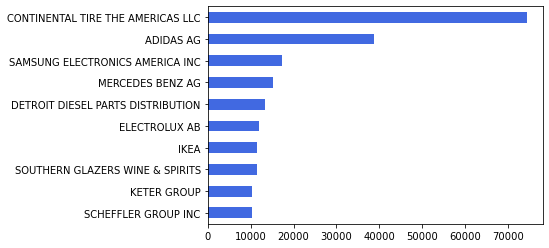

In [23]:
df['importer_deduped_name'].value_counts().head(10).sort_values().plot(kind='barh', color="royalblue")

In [24]:
df_top1 = df[df['importer_deduped_name'] == 'CONTINENTAL TIRE THE AMERICAS LLC']
df_top1['product'].value_counts()

Plastics / Rubbers                   73507
Machinery / Electrical                 219
Metals                                 197
Transportation                         117
Chemicals & Allied Industries           86
Wood & Wood Products                    61
Textiles                                44
Miscellaneous                           20
Mineral Products                         9
Foodstuffs                               6
Animal & Animal Products                 2
Raw Hides, Skins, Leather, & Furs        2
Stone / Glass                            1
Name: product, dtype: int64

In [25]:
df_top1 = df[df['importer_deduped_name'] == 'ADIDAS AG']
df_top1['product'].value_counts()

Textiles                                                          18686
Footwear / Headgear                                               17263
Plastics / Rubbers                                                 1106
Miscellaneous                                                      1023
Animal & Animal Products                                            238
Raw Hides, Skins, Leather, & Furs                                   150
Vegetable Products                                                   64
Metals                                                               59
Foodstuffs                                                           50
Chemicals & Allied Industries                                        29
Machinery / Electrical                                               12
Wood & Wood Products                                                  9
Stone / Glass                                                         7
Transportation                                                  

- **Continental Tire The Americas LLC** has the most number of imports followed by **Adidas AG**.

**Ranking of Importers by TEU**

<AxesSubplot:ylabel='importer_deduped_name'>

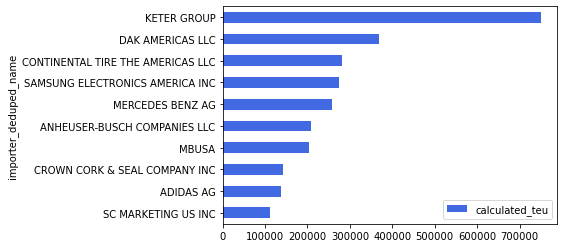

In [26]:
df.groupby('importer_deduped_name').agg({'calculated_teu':'sum'}).sort_values(by='calculated_teu', 
                        ascending=True).tail(10).plot(kind='barh', color="royalblue")

In [27]:
df_top1 = df[df['importer_deduped_name'] == 'KETER GROUP']
df_top1['product'].value_counts()

Plastics / Rubbers                   7528
Miscellaneous                        2730
Metals                                 16
Chemicals & Allied Industries          13
Raw Hides, Skins, Leather, & Furs      10
Wood & Wood Products                    7
Machinery / Electrical                  1
Name: product, dtype: int64

In [28]:
df_top2 = df[df['importer_deduped_name'] == 'DAK AMERICAS LLC']
df_top2['product'].value_counts()

Chemicals & Allied Industries    7390
Plastics / Rubbers                349
Textiles                            6
Machinery / Electrical              3
Name: product, dtype: int64

- **Keter Group** has the biggest cargos imported followed by **DAK Americas LLC, Continental Tire The Americas LLC, Samsung Electronics America Inc., and Mercedez Benz AG**.

### 1.2.2 Country Analysis

**Map Distribution of Imports**

In [29]:
import warnings
warnings.filterwarnings('ignore')

export_map = pd.DataFrame(df.groupby(['country_of_origin'])['calculated_teu'].sum().reset_index())
count = pd.DataFrame(export_map.groupby('country_of_origin')['calculated_teu'].sum().reset_index())

trace = [go.Choropleth(
            colorscale = 'Blues',
            locationmode = 'country names',
            locations = count['country_of_origin'],
            text = count['country_of_origin'],
            z = count['calculated_teu'])]

layout = go.Layout(title = 'US Imports from Other Countries')

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig)

**Country Share of Imports**

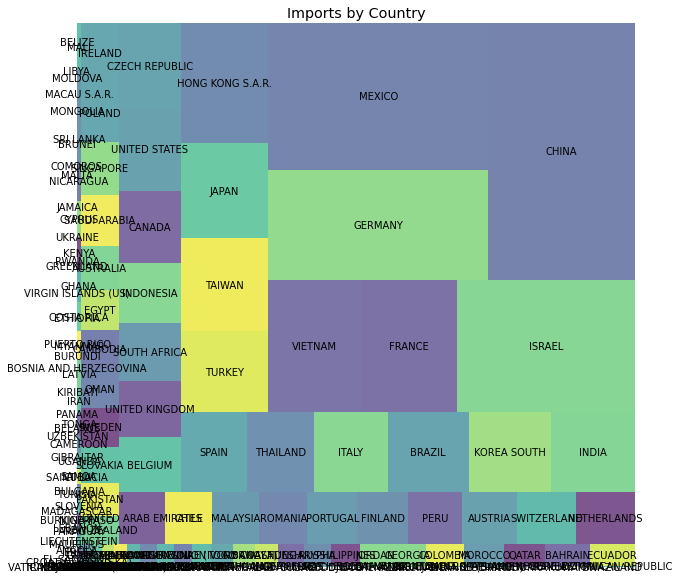

In [30]:
df4 = df.groupby(['country_of_origin']).agg({'calculated_teu': 'sum'})
df4 = df4.sort_values(by='calculated_teu')

value=np.array(df4)
country=df4.index
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 10.0)
squarify.plot(sizes=value, label=country, alpha=.7 )
plt.title("Imports by Country")
plt.axis('off')
plt.show()

**Ranking of Countries by Import Frequency**

<AxesSubplot:ylabel='country_of_origin'>

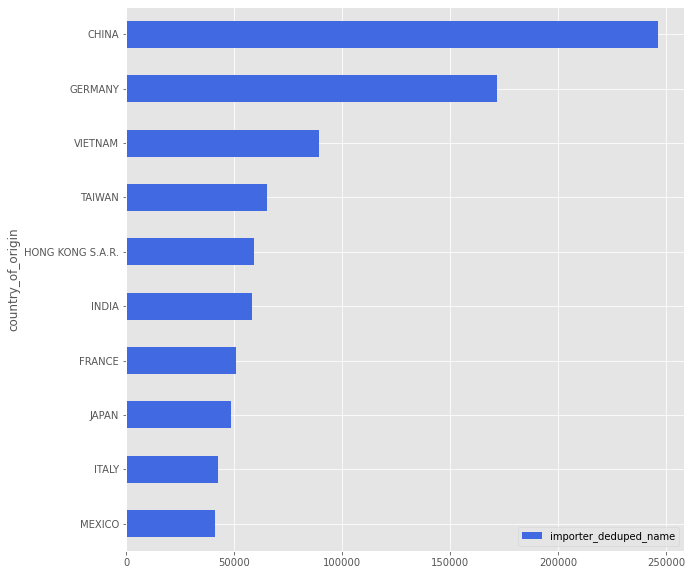

In [31]:
df.groupby('country_of_origin').agg({'importer_deduped_name':'count'}).sort_values(by='importer_deduped_name', 
                        ascending=True).tail(10).plot(kind='barh', color="royalblue")

In [32]:
df_top1 = df[df['country_of_origin'] == 'CHINA']
print(df_top1['product'].value_counts().head(5))
print(df_top1['importer_deduped_name'].value_counts().head(5))

Miscellaneous             71399
Machinery / Electrical    59514
Metals                    23748
Plastics / Rubbers        18425
Textiles                  14705
Name: product, dtype: int64
JO-ANN STORES INC               7953
ELECTROLUX AB                   7011
W S BADCOCK CORP                5549
ANHEUSER-BUSCH COMPANIES LLC    5491
THE HOME DEPOT INC              4443
Name: importer_deduped_name, dtype: int64


In [33]:
df_top2 = df[df['country_of_origin'] == 'GERMANY']
print(df_top2['product'].value_counts().head(5))
print(df_top2['importer_deduped_name'].value_counts().head(5))

Machinery / Electrical           44231
Plastics / Rubbers               28488
Transportation                   26481
Metals                           20721
Chemicals & Allied Industries    12025
Name: product, dtype: int64
MERCEDES BENZ AG                     13362
CONTINENTAL TIRE THE AMERICAS LLC     9964
SCHEFFLER GROUP INC                   6661
HELLA KGAA HUECK & CO                 5170
ZF CHASSIS SYSTEMS DUNCAN LLC         3820
Name: importer_deduped_name, dtype: int64


- **China** and **Germany** have the highest number of imports.

**Ranking of Countries by TEU**

<AxesSubplot:ylabel='country_of_origin'>

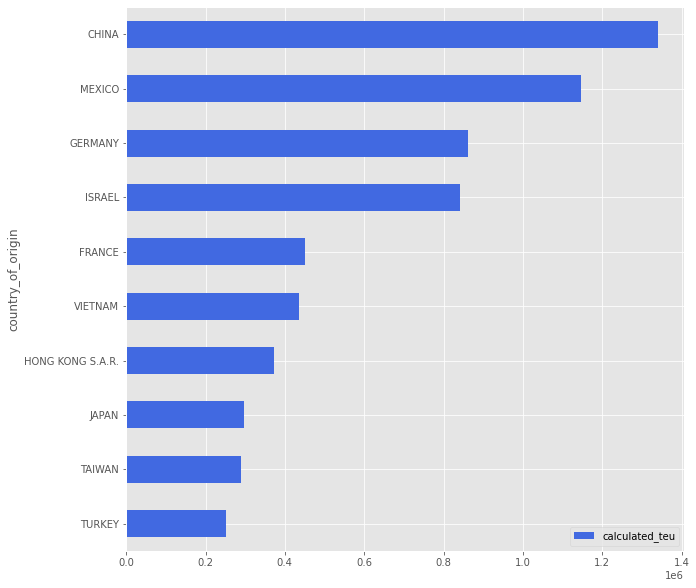

In [34]:
df.groupby('country_of_origin').agg({'calculated_teu':'sum'}).sort_values(by='calculated_teu', 
                            ascending=True).tail(10).plot(kind='barh', color="royalblue")

In [35]:
df_top2 = df[df['country_of_origin'] == 'MEXICO']
print(df_top2['product'].value_counts().head(5))
print(df_top2['importer_deduped_name'].value_counts().head(5))

Chemicals & Allied Industries    16297
Machinery / Electrical           13522
Transportation                    2593
Foodstuffs                        2022
Plastics / Rubbers                1459
Name: product, dtype: int64
SAMSUNG ELECTRONICS AMERICA INC          10299
DAK AMERICAS LLC                          7138
NOVAPET, SA                               1812
CIA INTEGRADA TEXTIL DE PERNAMBUCO SA     1703
INDORAMA VENTURES POLYMERS                1673
Name: importer_deduped_name, dtype: int64


- **China** and **Mexico** had the highest imports in terms of TEU.

### 1.2.3 Product/Commodity Analysis

**Ranking of Products by Import Frequency**

<AxesSubplot:>

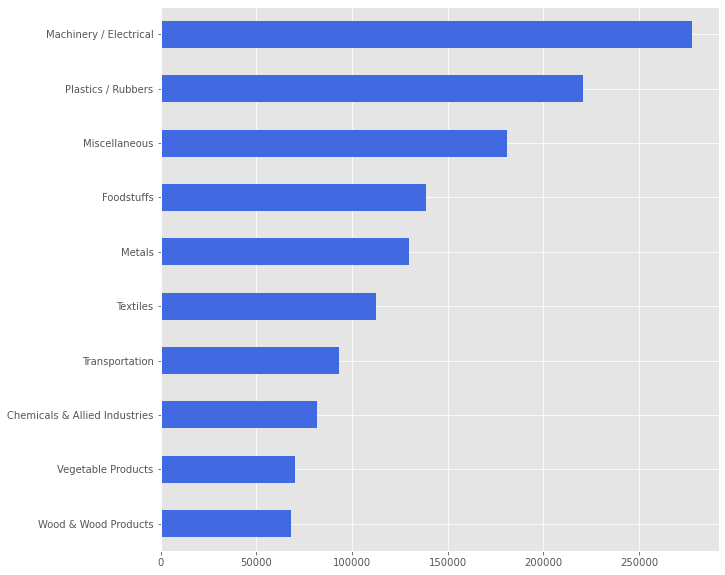

In [36]:
df['product'].value_counts().head(10).sort_values().plot(kind='barh', color="royalblue")

- Most imported products are **Machinery/Electrical** and **Plastics/Rubbers**. 

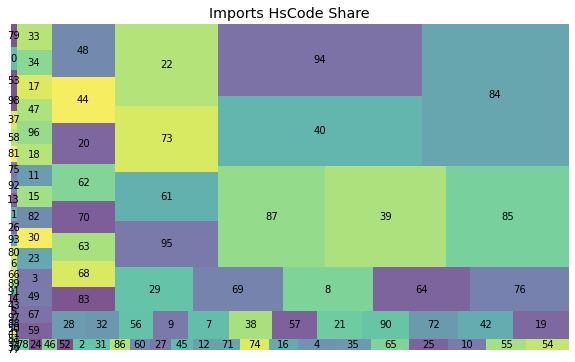

In [37]:
df3 = df.groupby(['hs_short']).agg({'name': 'count'})
df3 = df3.sort_values(by='name')

value=np.array(df3)
commodityCode=df3.index
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
squarify.plot(sizes=value, label=commodityCode, alpha=.7 )
plt.axis('off')
plt.title("Imports HsCode Share")
plt.show()

- **HsCode 84** (Nuclear Reactors, Boilers, Machinery and Mechanical Appliances; Parts Thereof), **HsCode 94** (Furniture; Bedding, Mattresses, Mattress Supports, Cushions and Similar Stuffed Furnishings; Lamps and Lighting Fittings, N.E.C.; Illuminated Signs, Illuminated Name-Plates and The Like; Prefabricated Buildings), and **HSCode 40** (Rubber and Articles thereof) were most frequently imported products.

**Ranking of Products by Import TEU**

<AxesSubplot:ylabel='product'>

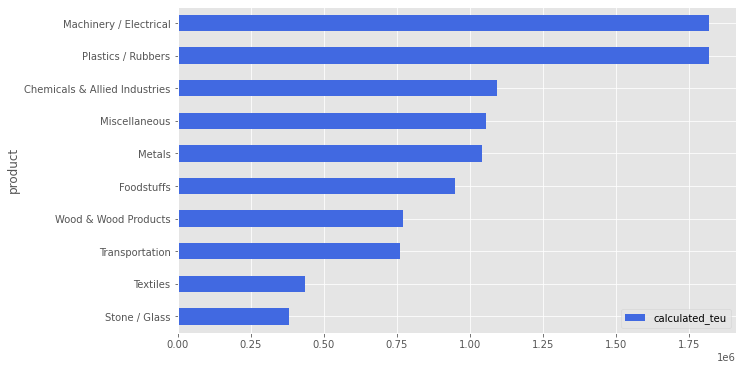

In [38]:
df.groupby('product').agg({'calculated_teu':'sum'}).sort_values(by='calculated_teu', 
                            ascending=True).tail(10).plot(kind='barh', color="royalblue")

- Most imported products in terms of TEU are **Machinery/Electrical** and **Plastics/Rubbers**.

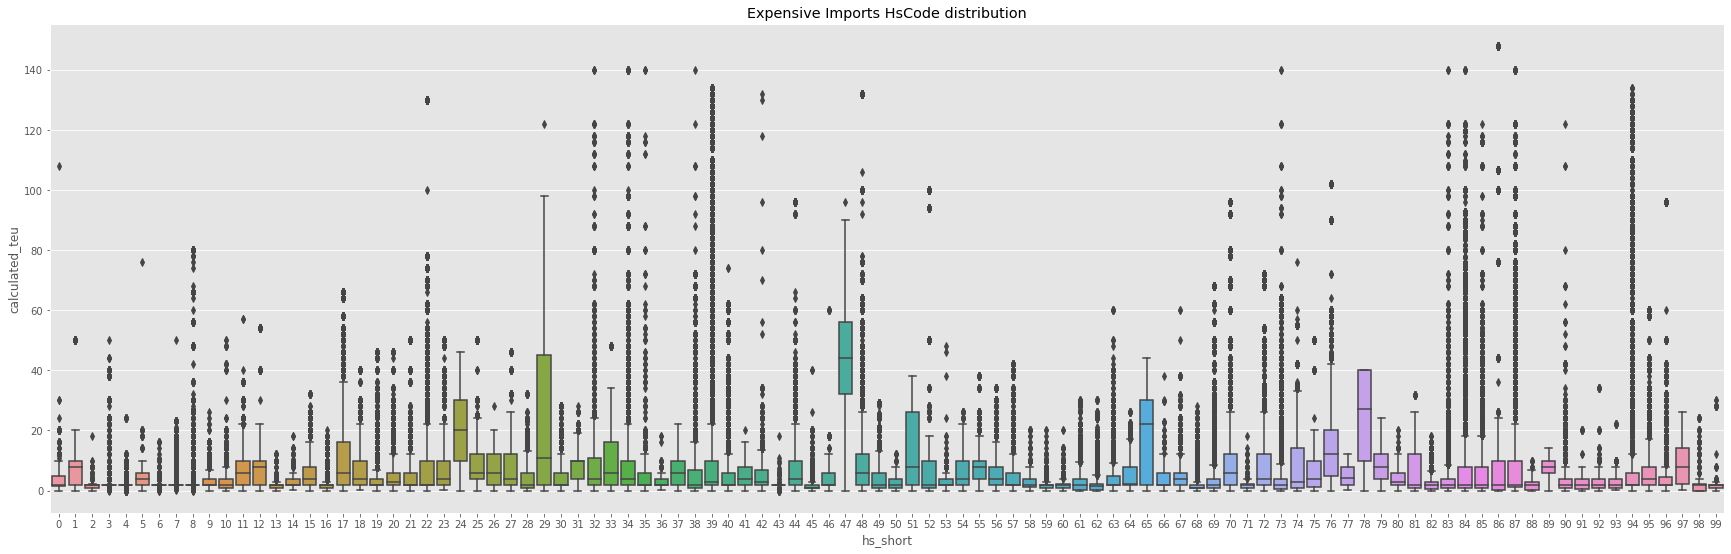

In [39]:
plt.figure(figsize=(30,9))

ax = sns.boxplot(x="hs_short", y="calculated_teu", data=df).set_title('Expensive Imports HsCode distribution')
plt.show()

- **HSCode 47** (Wood & Wood Products) tops the biggest import followed by **HSCode 78** (Metals), 65 (Footwear / Headgear), and **HSCode 24** (Foodstuffs).

### 1.2.4 Monthly Imports Analysis

**2021 Monthly Imports**

<AxesSubplot:title={'center':'Monthly Imports by Frequency'}, xlabel='file_month'>

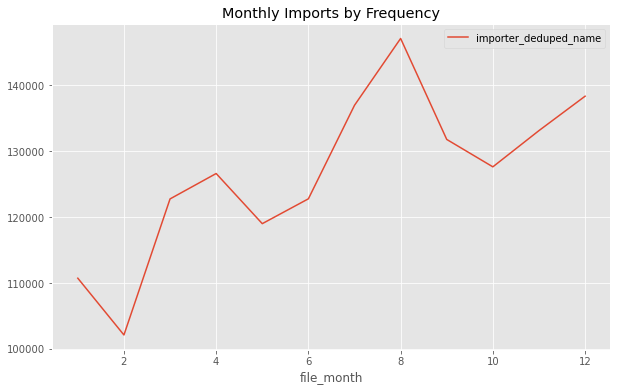

In [40]:
df.groupby('file_month').agg({'importer_deduped_name':'count'}).plot(kind='line', title='Monthly Imports by Frequency')

- Highest number of imports are in **August** while lowest number of imports are in **February**.

<AxesSubplot:title={'center':'Monthly Imports by TEU'}, xlabel='file_month'>

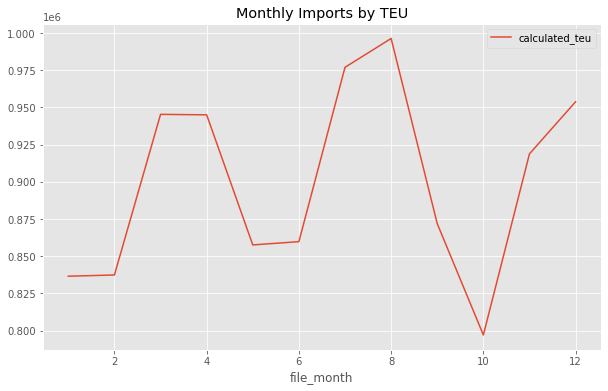

In [41]:
df.groupby('file_month').agg({'calculated_teu':'sum'}).plot(kind='line', title='Monthly Imports by TEU')

- Biggest import was in **August** while the lowest was in **October**

## 3. Importer Clustering

In [42]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### 3. 1 Data Cleansing

In [43]:
# check for missing values
df.isnull().sum()

name                     0
address                  0
calculated_teu           0
file_month               0
port_of_unlading         0
country_of_origin        0
hs_codes                 0
month_name               0
port_name                0
importer_rank            0
importer_deduped_name    0
hs_short                 0
product                  0
dtype: int64

To drop rows with missing values:

In [44]:
df = df.dropna()
df.shape

(1518633, 13)

In [45]:
# Create a date column
df['date'] = df['month_name'] + " 1, " + "2021" 

In [46]:
# change the datatype of InvoiceDate from string to datetime
df['date'] = pd.to_datetime(df['date'])

### 3.2 Data Preparation

We are going to perform an analysis based on the following factors:

- **R (Recency)**: Number of days since last purchase/payment
- **F (Frequency)**: Number of tracsactions
- **M (Monetary)**: Total amount of transactions (revenue contribution); in this case, the total TEU

**For the Monetary attribute:**

In [47]:
rfm_m = df.groupby('importer_deduped_name')['calculated_teu'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,importer_deduped_name,calculated_teu
0,(ZEN-NOH) NATIONAL FEDERATION OF AGRICULTURAL ...,274.000000
1,1-800-FLOWERS.COM INC,157.000000
2,1027 WILSHIRE JV LLC,278.819076
3,14 KARAT HOME INC,12.000000
4,18946 HWY 37 SOUTH,6.000000


In [48]:
# check calculated_teu <= 0
rfm_m[rfm_m['calculated_teu'] == 0]

,importer_deduped_name,calculated_teu
2074,DRAGON STONE ENERGY LTD,0.0
4961,NASOYA FOODS USA LLC,0.0
6380,SEOHAN AUTO USA CORP,0.0
6948,SWEDISH STEEL AB,0.0
7531,"UCHIYAMA MANUFACTURING AMERICA,LLC.",0.0


In [49]:
# only get calculated teu > 0 (dropping DRAGON STONE ENERGY LTD	, NASOYA FOODS USA LLC, 
# SEOHAN AUTO USA CORP, SWEDISH STEEL AB, UCHIYAMA MANUFACTURING AMERICA,LLC.)
rfm_m = rfm_m[rfm_m['calculated_teu'] > 0]

**For the Frequency attribute**:

In [50]:
rfm_f = df.groupby('importer_deduped_name')['date'].count() #you can also use other columns here
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['importer_deduped_name', 'Frequency']
rfm_f.head()

,importer_deduped_name,Frequency
0,(ZEN-NOH) NATIONAL FEDERATION OF AGRICULTURAL ...,22
1,1-800-FLOWERS.COM INC,22
2,1027 WILSHIRE JV LLC,54
3,14 KARAT HOME INC,4
4,18946 HWY 37 SOUTH,3


**For the Recency attribute**:

In [51]:
# compute the maximum date to know the last transaction date
max_date = max(df['date'])
max_date

Timestamp('2021-12-01 00:00:00')

In [52]:
# compute the difference between maximum date and import date
df['Diff'] = max_date - df['date']
df.head()

,name,address,calculated_teu,file_month,port_of_unlading,country_of_origin,hs_codes,month_name,port_name,importer_rank,importer_deduped_name,hs_short,product,date,Diff
3,BSN MEDICAL GMBH,"400 OLMOS BLVD STE A HIDALGO TX 78557 US, clea...",0.035356,1,5301,GERMANY,5806 2000,January,"Houston, Texas",8267.0,BSN MEDICAL GMBH,58,Textiles,2021-01-01,334 days
11,ZGEAR LLC,"1816 S JACKSON MAGNOLIA AR 71753 US, cleaned_a...",0.297372,1,5301,POLAND,8471 7000,January,"Houston, Texas",8368.0,ZGEAR LLC,84,Machinery / Electrical,2021-01-01,334 days
13,WILLIAM H. KOPKE JR. INC,1000 NORTHERN BLVD SUITE 200 GREAT NECK NY 110...,2.000000,1,1101,PERU,0806 1000,January,"Philadelphia, Pennsylvania",221.0,WILLIAM H. KOPKE JR. INC,8,Vegetable Products,2021-01-01,334 days
14,IQI WAREHOUSING USA,"400 GANDY DANCER DR TRACY CA 95377 US, cleaned...",10.000000,1,5301,NETHERLANDS,0511 9985,January,"Houston, Texas",4655.0,IQI WAREHOUSING USA INC,5,Animal & Animal Products,2021-01-01,334 days
15,IQI WAREHOUSING USA,"400 GANDY DANCER DR TRACY CA 95377 US, cleaned...",10.000000,1,5301,NETHERLANDS,0511 9985,January,"Houston, Texas",4655.0,IQI WAREHOUSING USA INC,5,Animal & Animal Products,2021-01-01,334 days


In [53]:
# ompute last import date to get the recency of importers
rfm_p = df.groupby('importer_deduped_name')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,importer_deduped_name,Diff
0,(ZEN-NOH) NATIONAL FEDERATION OF AGRICULTURAL ...,91 days
1,1-800-FLOWERS.COM INC,0 days
2,1027 WILSHIRE JV LLC,61 days
3,14 KARAT HOME INC,214 days
4,18946 HWY 37 SOUTH,244 days


In [54]:
# drop the diff column
df.drop(columns='Diff', inplace=True)

In [55]:
# get the exact number of days
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,importer_deduped_name,Diff
0,(ZEN-NOH) NATIONAL FEDERATION OF AGRICULTURAL ...,91
1,1-800-FLOWERS.COM INC,0
2,1027 WILSHIRE JV LLC,61
3,14 KARAT HOME INC,214
4,18946 HWY 37 SOUTH,244


In [56]:
# add one day to the 'Diff' column to avoid -inf in the log conversion
rfm_p['Diff'] = rfm_p['Diff'] + 1

**Merge the Recency, Frequency, and Monetary datasets**:

In [57]:
rfm_fm = rfm_m.merge(rfm_f, on='importer_deduped_name', how='inner')
rfm = rfm_fm.merge(rfm_p, on='importer_deduped_name', how='inner')
rfm.columns = ['importer_deduped_name', 'Amount', 'Frequency', 'Recency']
rfm.head()

,importer_deduped_name,Amount,Frequency,Recency
0,(ZEN-NOH) NATIONAL FEDERATION OF AGRICULTURAL ...,274.000000,22,92
1,1-800-FLOWERS.COM INC,157.000000,22,1
2,1027 WILSHIRE JV LLC,278.819076,54,62
3,14 KARAT HOME INC,12.000000,4,215
4,18946 HWY 37 SOUTH,6.000000,3,245


**Outliers**

There are 2 types of outliers and we will treat outliers as it can skew our dataset:

- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

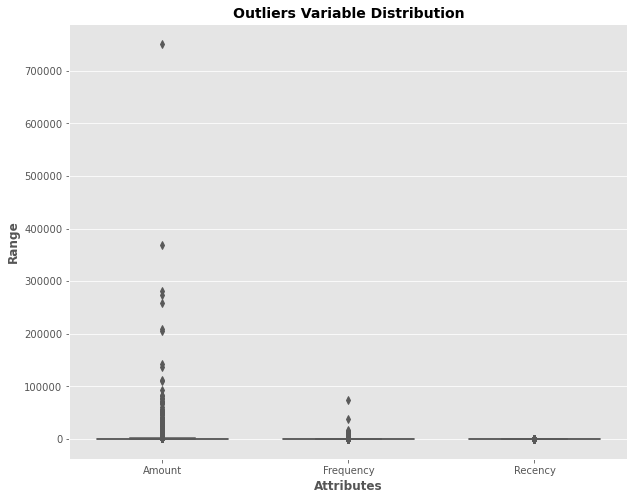

In [58]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [59]:
# remove statistical outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

In [60]:
# remove statistical outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [61]:
# remove the statistical outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

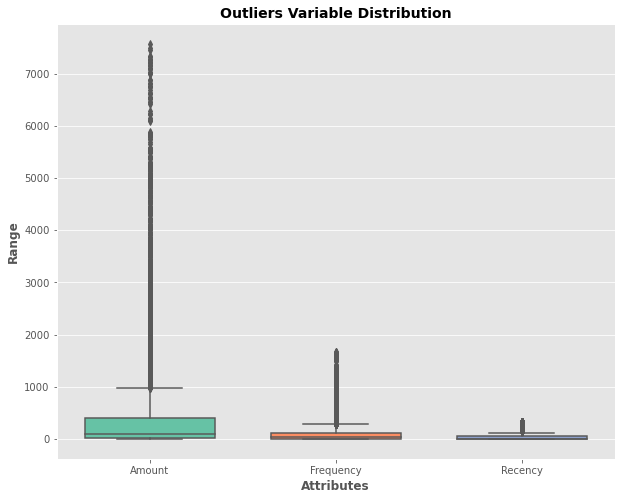

In [62]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

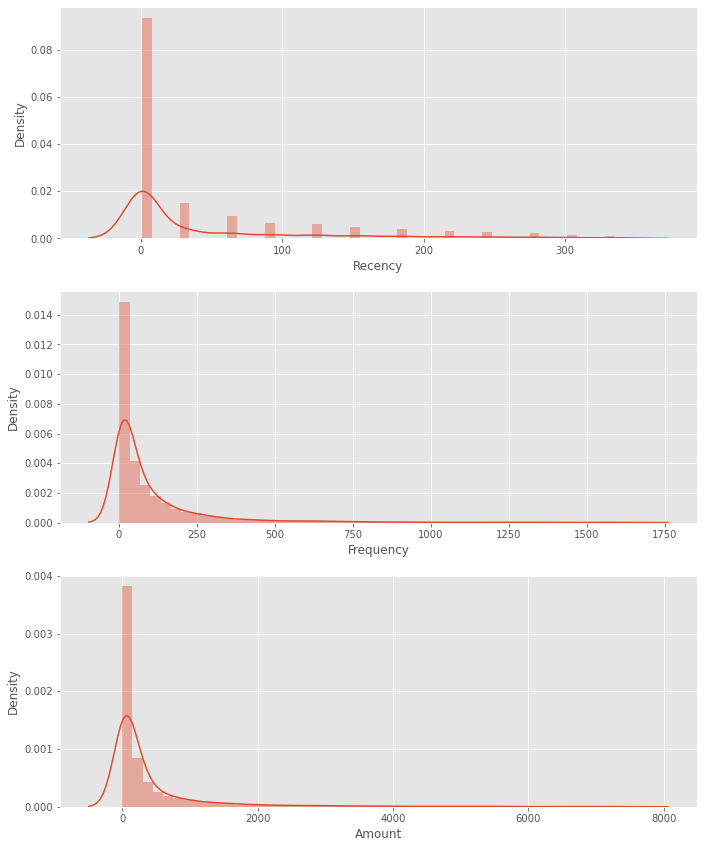

In [63]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Amount, label = 'Amount')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

**Log Transformation**

In [64]:
#Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'Amount']].apply(np.log, axis = 1).round(3)

In [65]:
rfm_log.describe()

,Recency,Frequency,Amount
count,7912.000000,7912.000000,7912.000000
mean,1.672844,3.453896,4.399740
std,2.215309,1.739809,2.194265
min,0.000000,0.000000,-8.815000
25%,0.000000,2.197000,2.890000
50%,0.000000,3.584000,4.575000
75%,4.127000,4.771000,6.000250
max,5.814000,7.416000,8.932000


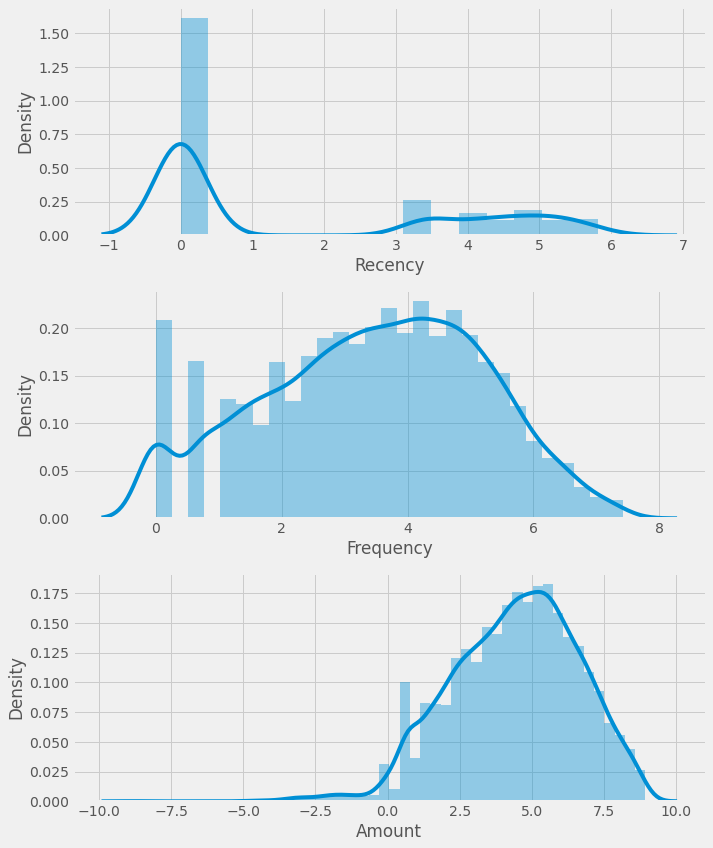

In [66]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.Amount, label = 'Amount')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

**Rescale**

It is extremely important to rescale the variables so that they have a comparable scale. There are two common ways of rescaling:

- Min-Max scaling
- Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [67]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(7912, 3)

In [68]:
# convert the array to a dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.196912,-0.442885,0.634899
1,-0.315950,-0.442885,-0.568722
2,-0.192009,-0.278689,0.238101
3,-0.463476,-0.535245,2.261771
4,-0.469581,-0.540376,2.658569


### 3.3 Modelling

K-means clustering is one of the simplest and popular unsupervised machine learning algorithm.

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

**Find the Optimal Number of Clusters**

Elbow Curve to get the right number of Clusters

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

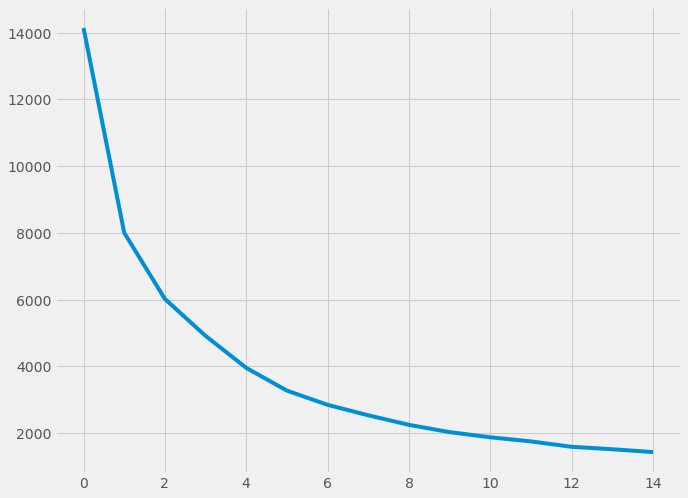

In [69]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

**Silhoutte Analysis**

p is the mean distance to the points in the nearest cluster that the data point is not a part of

q is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1.

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

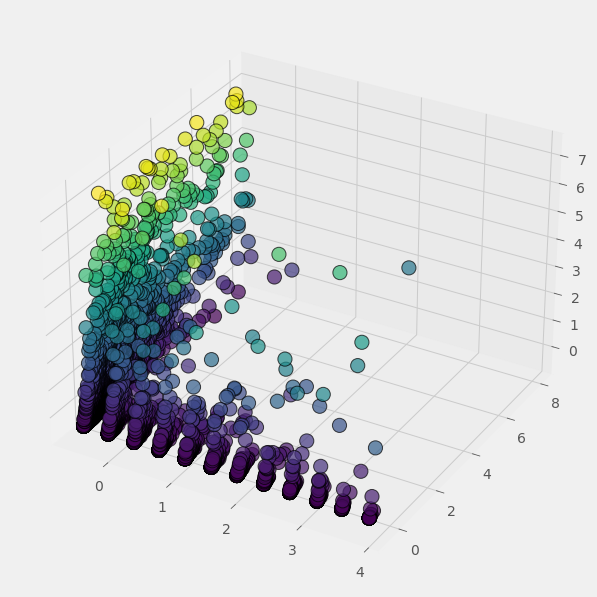

In [70]:
#create a 3D scatter plot for the df
X = rfm_df_scaled['Recency']
y = rfm_df_scaled['Frequency']
z = rfm_df_scaled['Amount']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [71]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6699654349763597
For n_clusters=3, the silhouette score is 0.6082976606099454
For n_clusters=4, the silhouette score is 0.5809335023469532
For n_clusters=5, the silhouette score is 0.5705457590705754
For n_clusters=6, the silhouette score is 0.5359202308459305
For n_clusters=7, the silhouette score is 0.5353784079824109
For n_clusters=8, the silhouette score is 0.520565873592917
For n_clusters=9, the silhouette score is 0.5195457071900151
For n_clusters=10, the silhouette score is 0.5194942012870168
For n_clusters=11, the silhouette score is 0.4729680278388168
For n_clusters=12, the silhouette score is 0.48832982806499525


In [72]:
# Final model with k=4
# edit the number of clusters
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=123)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4, random_state=123)

In [73]:
kmeans.labels_

array([0, 0, 0, ..., 1, 0, 0])

In [74]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,importer_deduped_name,Amount,Frequency,Recency,Cluster_Id
0,(ZEN-NOH) NATIONAL FEDERATION OF AGRICULTURAL ...,274.000000,22,92,0
1,1-800-FLOWERS.COM INC,157.000000,22,1,0
2,1027 WILSHIRE JV LLC,278.819076,54,62,0
3,14 KARAT HOME INC,12.000000,4,215,2
4,18946 HWY 37 SOUTH,6.000000,3,245,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

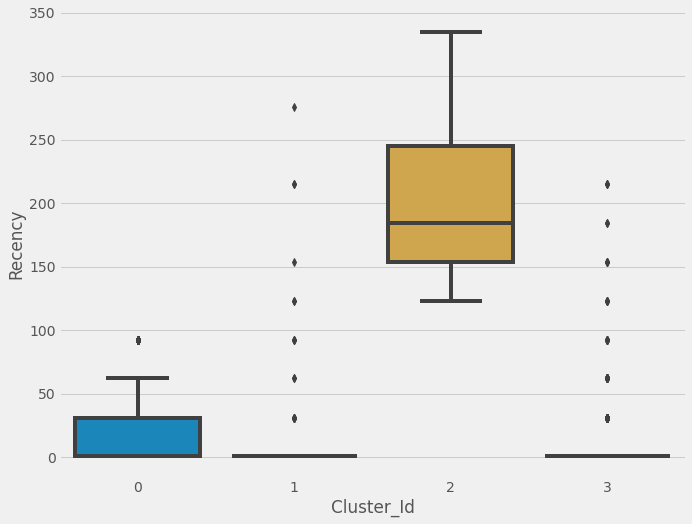

In [75]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

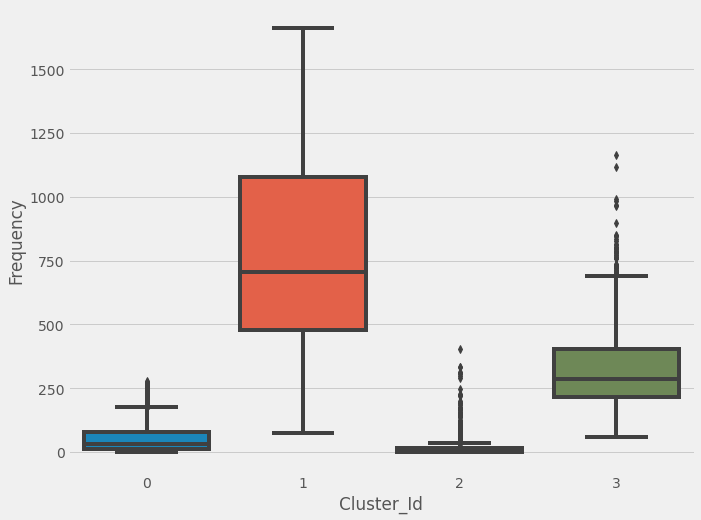

In [76]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

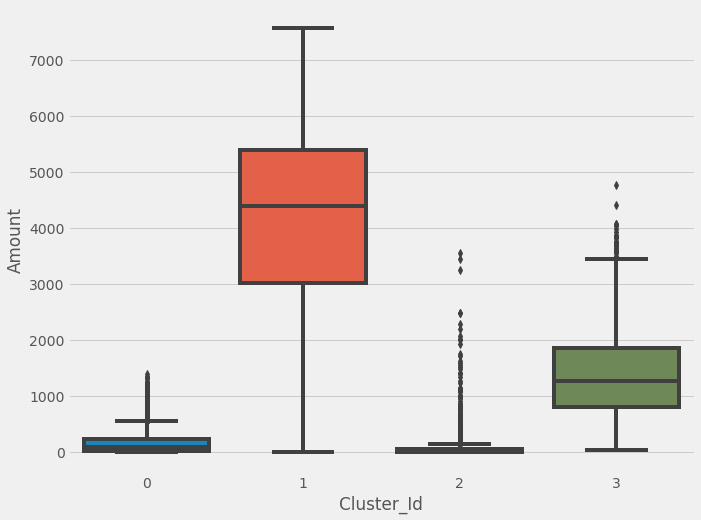

In [77]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

In [78]:
rfm['Cluster_Id'].value_counts()

0    5334
2    1291
3     999
1     288
Name: Cluster_Id, dtype: int64

### 3.4 Final Analysis

K-Means Clustering with 4 Cluster IDs

- Importers under Cluster ID 2 have the highest teu, and most frequent and recent transactions.
- Importers under Cluster ID 3 have high teu, frequent transactions, and most recent transactions.
- Importers under Cluster ID 0 have low teu, few transactions, and haven't imported recently.
- Importers under Cluster ID 1 have the lowest teu, frequency, and haven't imported within the last 4 months.

In [79]:
# grade of importers from A to D, high value to lowest value
rfm['Cluster_Id'].replace(2, "A", inplace=True)
rfm['Cluster_Id'].replace(3, "B", inplace=True)
rfm['Cluster_Id'].replace(0, "C", inplace=True)
rfm['Cluster_Id'].replace(1, "D", inplace=True)

In [80]:
rfm.sort_values(by=['Cluster_Id','importer_deduped_name'], inplace=True)

In [81]:
# raname Cluster_Id column to Investment_Grade column
rfm.rename(columns = {'Cluster_Id':'Investment_Grade'}, inplace = True)

In [82]:
rfm.head()

,importer_deduped_name,Amount,Frequency,Recency,Investment_Grade
3,14 KARAT HOME INC,12.000000,4,215,A
4,18946 HWY 37 SOUTH,6.000000,3,245,A
7,2583319 ONTARIO INC,2.000000,1,276,A
8,26 INTERNATIONAL INC,4.000000,2,154,A
17,5.11 TACTICAL,16.212186,10,154,A


In [83]:
rfm.to_csv('output.csv', index = False)

In [84]:
df.to_csv('cleaned.csv', index = False)

In [85]:
print('The End.')

The End.


## 4. Forecasting Imports

In [86]:
# Aggregate to monthly level the required metrics

monthly_imports=df.groupby(["file_month","hs_codes"])[
    "date","calculated_teu","name"].agg({"date":["min",'max'],"calculated_teu":"mean","name":"count"})

## Lets break down the line of code here:
# aggregate by file_month,name, and hs_codes
# select the columns date,calculated_teu and count of transactions(name count)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the calculated_teu
# sum of the transactions

In [87]:
# take a peak
monthly_imports.head(20)

date            calculated_teu  name
                            min        max           mean count
file_month hs_codes                                            
1          0000 0000 2021-01-01 2021-01-01       3.564133    72
           0000 0665 2021-01-01 2021-01-01       1.000000     1
           0000 5560 2021-01-01 2021-01-01       2.000000     1
           0001 0000 2021-01-01 2021-01-01       5.000000     4
           0002 1800 2021-01-01 2021-01-01       0.034934     1
           0008 8834 2021-01-01 2021-01-01      10.000000     4
           0010 0000 2021-01-01 2021-01-01       2.000000     2
           0010 3444 2021-01-01 2021-01-01      16.000000     7
           0015 6262 2021-01-01 2021-01-01       2.000000     1
           0016 0689 2021-01-01 2021-01-01      11.000000     1
           0016 3517 2021-01-01 2021-01-01       2.000000     1
           0020 0000 2021-01-01 2021-01-01       0.398519     3
           0020 6302 2021-01-01 2021-01-01       3.000000     1
           0022 6200 2021-01-01 2021-01-01      10.000000     1
           0025 0000 2021-01-01 2021-01-01       2.000000     1
           0028 5700 2021-01-01 2021-01-01       6.000000     1
           0037 8258 2021-01-01 2021-01-01       1.000000     1
           0037 9981 2021-01-01 2021-01-01       1.000000     1
           0038 0949 2021-01-01 2021-01-01       3.000000     1
           0041 4500 2021-01-01 2021-01-01       2.000000     1

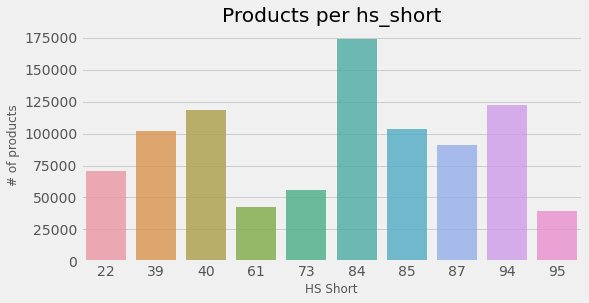

In [88]:
# number of items per cat 
x=df.groupby(['hs_short']).count()
x=x.sort_values(by='hs_codes',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.hs_short, x.hs_codes, alpha=0.8)
plt.title("Products per hs_short")
plt.ylabel('# of products', fontsize=12)
plt.xlabel('HS Short', fontsize=12)
plt.show()

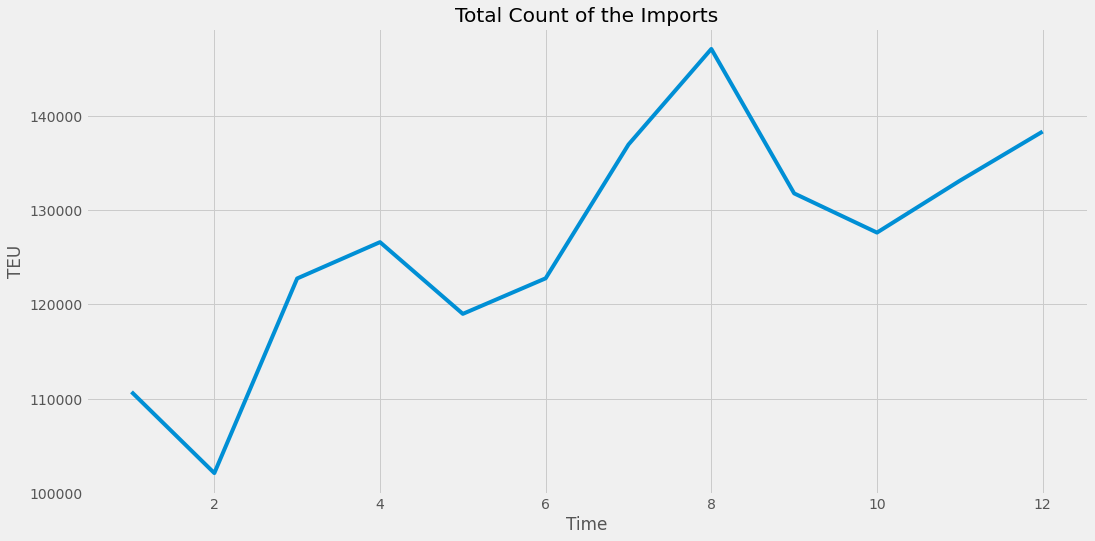

In [90]:
ti=df.groupby(["file_month"])["calculated_teu"].count()
ti.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Count of the Imports')
plt.xlabel('Time')
plt.ylabel('TEU')
plt.plot(ti);

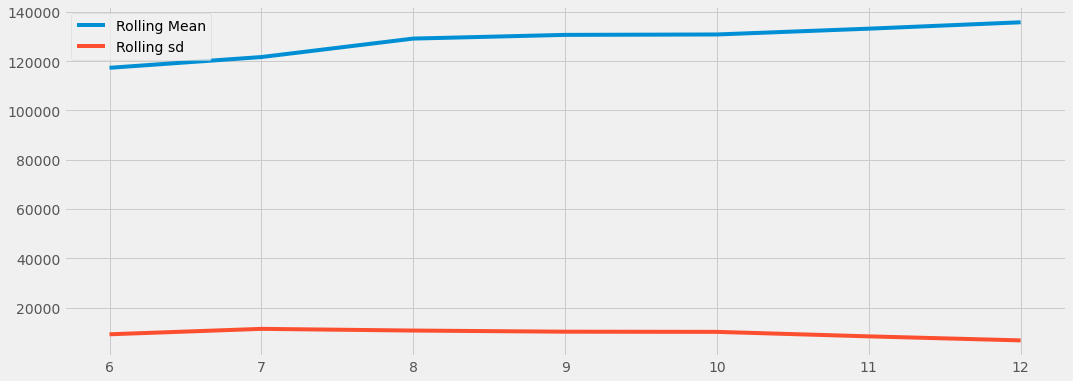

In [91]:
plt.figure(figsize=(16,6))
plt.plot(ti.rolling(window=6,center=False).mean(),label='Rolling Mean');
plt.plot(ti.rolling(window=6,center=False).std(),label='Rolling sd');
plt.legend();

There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

**Prophet**

Prophet follows the typical sklearn syntax.

At its core, the its procedure is an additive regression model with four main components:

- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

In [93]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ti.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ti) #fit the model with your dataframe

ModuleNotFoundError: No module named 'fbprophet'